In [1]:
_server_root = ""
_data_uuid = ""
_result_path = ""


In [2]:
# Parameters
_server_root = "/home/lyiran/neelptycho/server"
_data_uuid = "ba8b1be3-25b2-5124-a444-d4a94ab2050d"
_result_path = (
    "/home/lyiran/neelptycho/server/results/task_SimpleSimMag3_ePIE_padding_1"
)


In [3]:
import uuid
data_uuid = uuid.UUID(_data_uuid)
from pathlib import Path
result_path = Path(_result_path)
import sys, os
sys.path.append(_server_root)

In [4]:
# Timer
import time
start_time = time.time()

## ePIE Analysis

In [5]:
from library.data import get_data_path
import yaml
from library.utils import load_params, add_colordisk_hsv, complex_to_hsv, with_default_unit
import h5py
import tables
data_path = get_data_path(data_uuid)
p = load_params("ePIE")
with h5py.File(data_path, "r") as file:
    attrs = dict(file.attrs)
    dp_shape = file["/data"].shape[-2:]
    dps = file["/data"][()].reshape((attrs["height"], attrs["width"]) + dp_shape)

if "semiconv_pix" in p:
    attrs["semiconv_pix"] = p["semiconv_pix"]
if "rotation" in p:
    attrs["rotation"] = with_default_unit(p["rotation"], "degree")

if "defocus" not in p["ePIE"]:
    p["ePIE"]["defocus"] = 0
p["ePIE"]["defocus"] = with_default_unit(p["ePIE"]["defocus"], "m")

In [6]:
from epie.param_manager import ParamTree, PtychoParams, DatasetParams, NumericalParams
from epie.utils import wavelength
dataset_params = ParamTree(
    # Base dataset information
    dataset_name=attrs["name"],
    format="mib",
    acquisition_time=attrs["datetime"],
    # Scan/Diff Geometry
    scan_height_raw=attrs["height"], # the true number of scan rows acquired before pre-processing
    scan_width_raw=attrs["width"], # the true number of scan columns acquired before pre-processing
    scan_origin="top-left", # where does the scan coordinate system have its origin
                           # a string combination of 'top/bottom-left/right'
                           # top implies positive=downwards, right implies positive=leftwards
    scan_skip_rows=(0,0), # number of rows to skip at start (origin) and end of height
    scan_skip_cols=(0,0), # number of columns to skip at start (origin) and end of width
    scan_step_row_ang=attrs["stepsize"] * 1e10, # scan step in angstroms between rows
    scan_step_col_ang=attrs.get("stepsize_y", attrs["stepsize"]) * 1e10, # scan step in angstroms between columns
    scan_to_diff_rot_deg=attrs["rotation"], # rotation in degrees from a scan coordinate dimension to equivalent diffraction pattern coordinate
    diff_height_raw=dps.shape[2], # the true number of diff rows per-frame before pre-processing
    diff_width_raw=dps.shape[3], # the true number of diff columns per-frame before pre-processing
    diff_origin="top-left", # same definition as scan_origin
    # Acquisition parameters
    aperture_size_mrad=attrs["semiconv"] * 1e3,
    aperture_size_px=attrs["semiconv_pix"],
    beam_voltage_kv=attrs["voltage"],
    defocus_ang=p["ePIE"]["defocus"] * 1e10,
    pixel_size_detector_m=attrs["psize"], # in metres
    # Processed dataset dimensions
    # These values are used in preference to the above ones when present
    scan_height=attrs["height"],
    scan_width=attrs["width"],
    diff_height=dps.shape[2],
    diff_width=dps.shape[3],
    #wavelength_m=wavelength(attrs["voltage"]),
    #wavelength_pm=wavelength(attrs["voltage"])*1e12
)
reconst_params = ParamTree(
    enable_circular_cutoff=p["ePIE"].get("enable_circular_cutoff", False),
    diff_cutoff_radius_fraction=p["ePIE"]["diff_cutoff_radius_fraction"],
    diff_intensity_lower_cutoff=p["ePIE"]["diff_intensity_lower_cutoff"],
    diff_origin_shift=p["ePIE"]["diff_origin_shift"],
    diff_padding_factor=p["ePIE"]["diff_padding_factor"],
    diff_stride=p["ePIE"]["diff_stride"],
    binning_factor=p["ePIE"].get("binning_factor", 1),
    n_iteration_frozen_probe=p["ePIE"]["n_iteration_frozen_probe"],
    n_iteration_frozen_object=p["ePIE"].get("n_iteration_frozen_object", 0),
    probe_update_interval=p["ePIE"].get("probe_update_interval", 1),
    n_iteration_target=p["ePIE"]["n_iteration_target"],
    scan_stride=p["ePIE"]["scan_stride"],
    alpha=p["ePIE"]["alpha"],
    beta=p["ePIE"]["beta"],
    force_aperture_mask=p["ePIE"].get("force_aperture_mask", False),
    force_weak_phase_approx=p["ePIE"].get("force_weak_phase_approx", False),
    force_relative=p["ePIE"].get("force_relative", False)
)

import yaml
print("--- data.yaml ---")
print(yaml.dump(dataset_params))
print("--- reconst.yaml ---")
print(yaml.dump(reconst_params))

--- data.yaml ---
!!python/object/new:epie.param_manager.ParamTree
dictitems:
  acquisition_time: !!python/object/apply:numpy.core.multiarray.scalar
  - !!python/object/apply:numpy.dtype
    args:
    - S19
    - false
    - true
    state: !!python/tuple
    - 3
    - '|'
    - null
    - null
    - null
    - 19
    - 1
    - 0
  - !!binary |
    MjAyNC0wNy0wMVQxMDo0MDowMA==
  aperture_size_mrad: !!python/object/apply:numpy.core.multiarray.scalar
  - &id001 !!python/object/apply:numpy.dtype
    args:
    - f8
    - false
    - true
    state: !!python/tuple
    - 3
    - <
    - null
    - null
    - null
    - -1
    - -1
    - 0
  - !!binary |
    AAAAAAAAFEA=
  aperture_size_px: !!python/object/apply:numpy.core.multiarray.scalar
  - *id001
  - !!binary |
    Mn4wS9KFCEA=
  beam_voltage_kv: !!python/object/apply:numpy.core.multiarray.scalar
  - &id002 !!python/object/apply:numpy.dtype
    args:
    - i4
    - false
    - true
    state: !!python/tuple
    - 3
    - <
    - null
   

In [7]:
# the pixel size of reconstructed image
cbed_dimension_reconst = dataset_params["diff_width"] / reconst_params["diff_stride"] * reconst_params["diff_padding_factor"]
resolution_reciprocal_space_rad = attrs["semiconv"] / attrs["semiconv_pix"] * reconst_params["diff_stride"]
resolution_reciprocal_space = resolution_reciprocal_space_rad / wavelength(attrs["voltage"])
resolution_real_space = 1.0 / (resolution_reciprocal_space * cbed_dimension_reconst)

print(f"Resolutions:")
print(f"  Reciprocal Space : {resolution_reciprocal_space_rad} rad")
print(f"  Reciprocal Space : {resolution_reciprocal_space / 1e10} Å^{-1}")
print(f"  Real Space       : {resolution_real_space * 1e10} Å")

Resolutions:
  Reciprocal Space : 0.0016311390926888362 rad
  Reciprocal Space : 0.03906196962496177 Å^-1
  Real Space       : 0.2000027155570665 Å


In [8]:
import numpy as np
if os.path.exists("probe_init.npy"):
    print("initial probe found")
    probe0 = np.load("probe_init.npy")
else:
    probe0 = None

if os.path.exists("object_init.npy"):
    print("initial object found")
    obj0 = np.load("object_init.npy")
else:
    obj0 = None

In [ ]:
from epie.lib import run_epie
from epie.gpu_utils import set_device
from pprint import pprint
params = PtychoParams()
params["dataset"] = DatasetParams(**dataset_params)
params["numerical"] = NumericalParams(**reconst_params)

print(params.dataset.__class__)
print(params.dataset.wavelength_pm)
pprint(params)

with set_device(dev_id=1):
    obj, probe = run_epie(dps, params, results_directory=result_path, probe0=probe0, obj0=obj0)

## Plot the results

In [10]:
import numpy as np
from scipy import ndimage
from library.utils import crop_image, sigma_e
from skimage.restoration import unwrap_phase

probe = np.load(result_path/"arrays"/f"probe_iter_{reconst_params['n_iteration_target']:04d}.npy")
transmission = np.load(result_path/"arrays"/f"obj_iter_{reconst_params['n_iteration_target']:04d}.npy")

probe_rot = ndimage.rotate(probe, angle=-attrs["rotation"])
trans_rot = crop_image(transmission,
                       size=(attrs["width"]*attrs["stepsize"], attrs["height"]*attrs["stepsize"]),
                       calibrations=resolution_real_space,
                       angle=-attrs["rotation"])

potential_real = unwrap_phase(np.angle(trans_rot))/sigma_e(accl=attrs["voltage"])
potential_imag = -np.log(np.absolute(trans_rot)) / sigma_e(accl=attrs["voltage"])
potential = potential_real + 1j * potential_imag

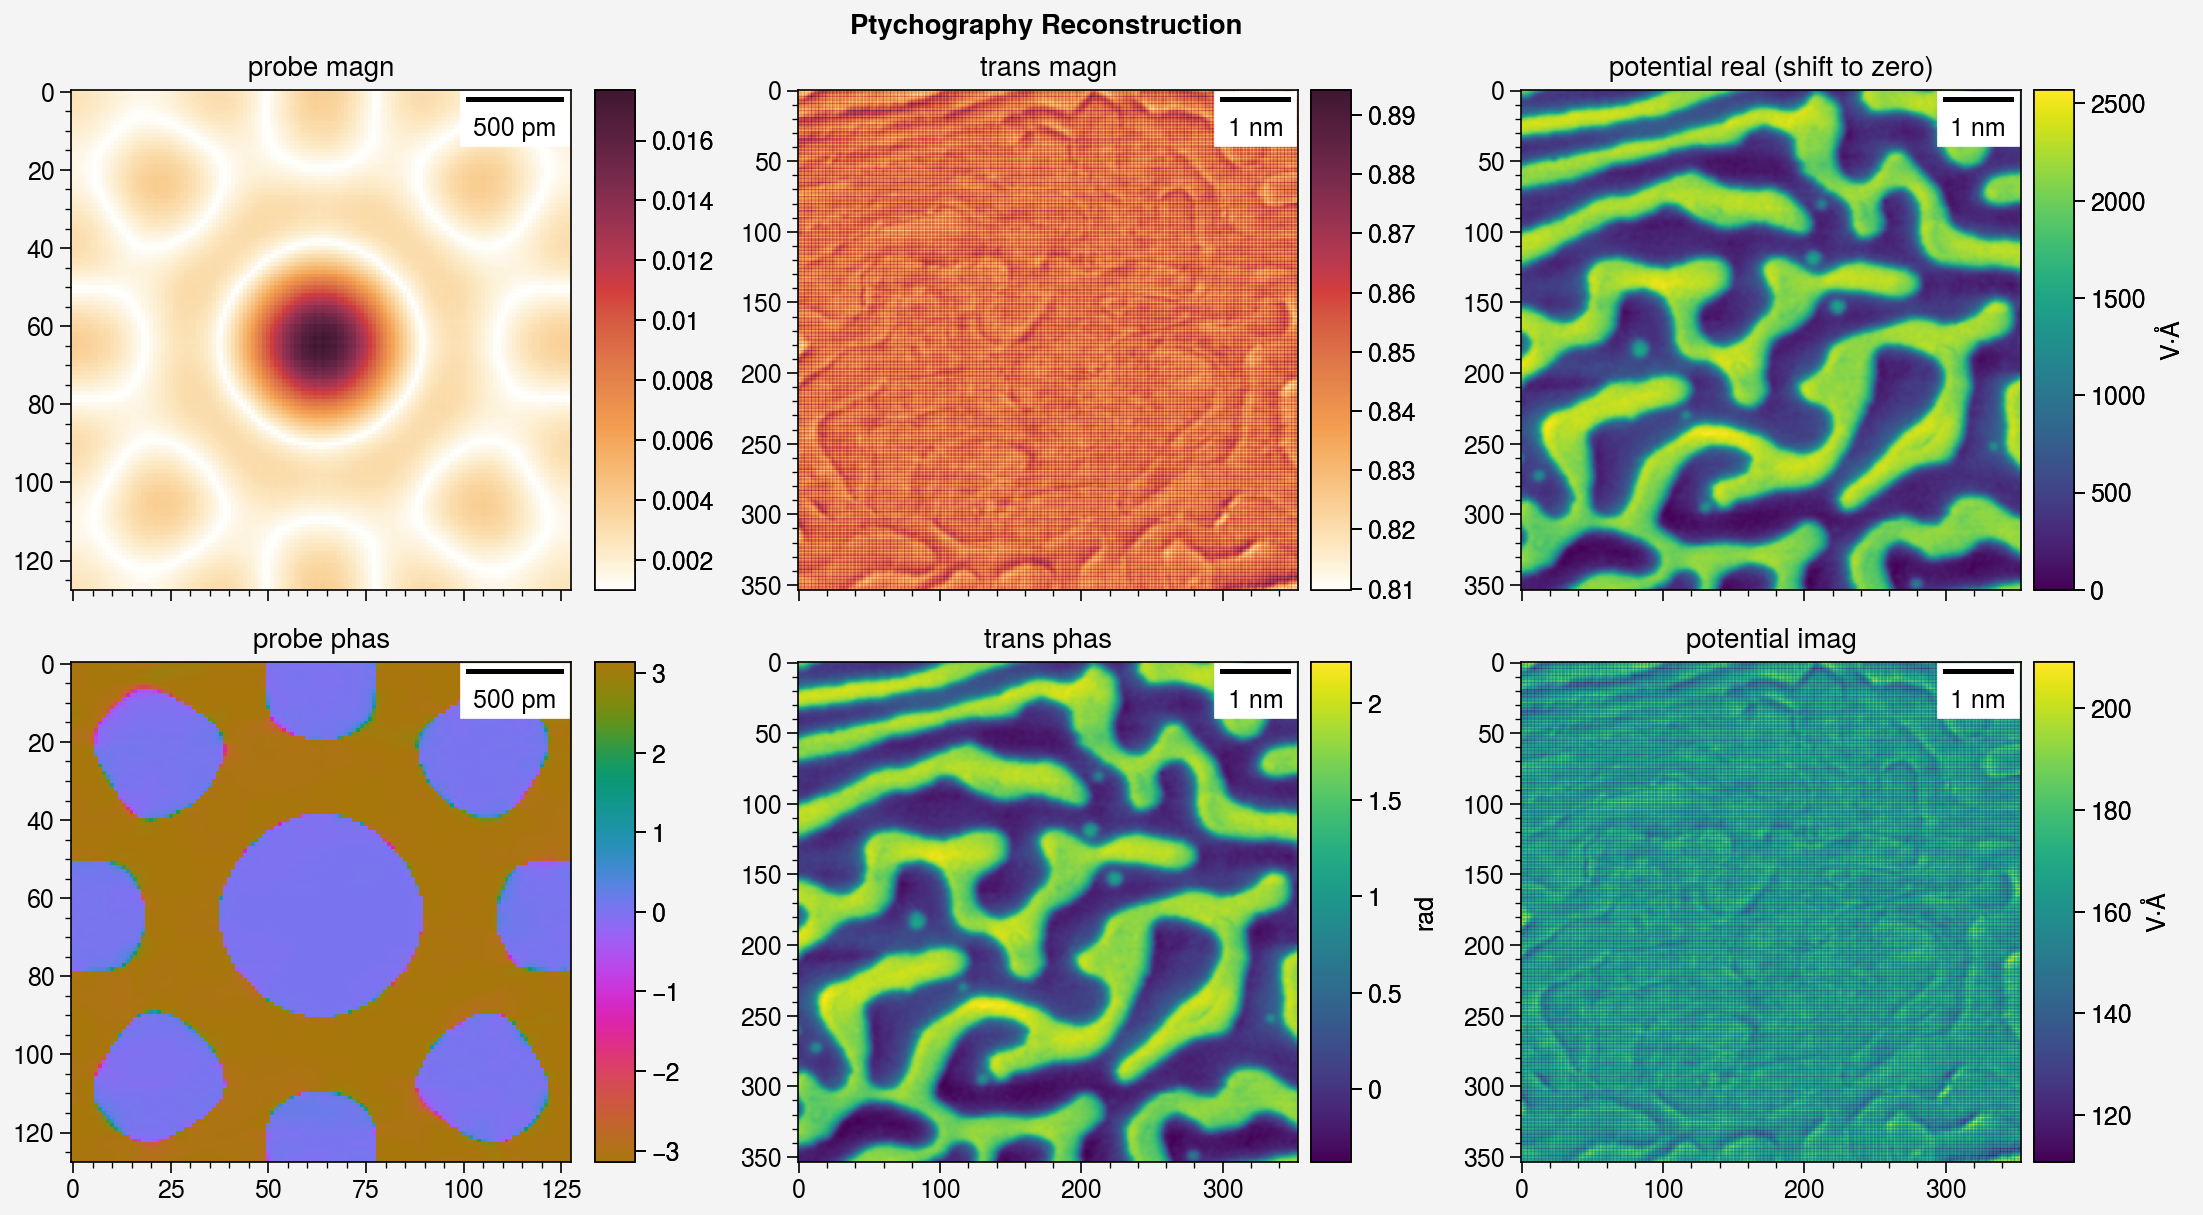

In [11]:
import matplotlib.pyplot as plt
from matplotlib import colors
import proplot as pplt
from matplotlib_scalebar.scalebar import ScaleBar
pplt.rc["grid"] = False

fig, axs = pplt.subplots(nrows=2, ncols=3, sharey=False, suptitle="Ptychography Reconstruction")

# probe image (magnitude and phase parts)
m = axs[0, 0].imshow(np.abs(probe_rot) + 1e-3)#, norm=colors.LogNorm())
axs[0, 0].format(title="probe magn")
axs[0, 0].colorbar(m, loc="r")

m = axs[1, 0].imshow(np.angle(probe_rot), cmap="phase", vmin=-np.pi, vmax=np.pi)
axs[1, 0].format(title="probe phas")
axs[1, 0].colorbar(m, loc="r")

# transmission function (magnitude and phase parts)
m = axs[0, 1].imshow(np.abs(trans_rot))
axs[0, 1].format(title="trans magn")
axs[0, 1].colorbar(m, loc="r")

m = axs[1, 1].imshow(np.angle(trans_rot), cmap="viridis")
axs[1, 1].format(title="trans phas")
axs[1, 1].colorbar(m, loc="r", label="rad")

# potential function (real and imaginary parts)
m = axs[0, 2].imshow((potential_real - potential_real.min()) * 1e10, cmap="viridis")
axs[0, 2].format(title="potential real (shift to zero)")
axs[0, 2].colorbar(m, loc="r", label="V$\cdot\AA$")

m = axs[1, 2].imshow(potential_imag * 1e10, cmap="viridis")
axs[1, 2].format(title="potential imag")
axs[1, 2].colorbar(m, loc="r", label="V$\cdot\AA$")

for i in range(2):
    for j in range(3):
        axs[i, j].add_artist(ScaleBar(resolution_real_space, "m", length_fraction=0.2))

pplt.show()
fig.savefig(result_path/"overview.png")

In [12]:
print(f"--- {time.time() - start_time} seconds ---")

--- 1599.816640138626 seconds ---


## Save the Results of the Final Iteration

In [13]:
np.save(result_path/"final_probe_rot.npy", probe_rot)
np.save(result_path/"final_trans_rot.npy", trans_rot)
np.save(result_path/"final_poten_rot.npy", potential)

## Fit Aberration in Probe Wave Function

In [14]:
from fitaber import fit_aber, coefs_all_up_to
import fitaber

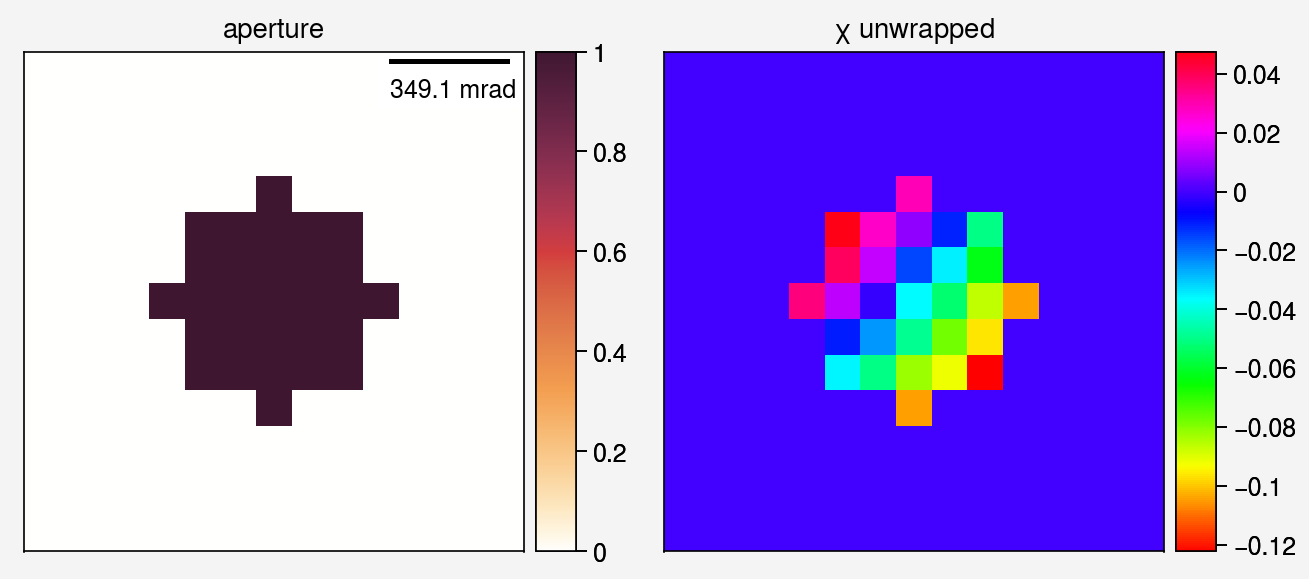

In [15]:
aperture = np.abs(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe_rot))))
aperture = (aperture > aperture.max()/2).astype(np.int32)
# chi = -np.angle(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe_rot)))) * aperture
chi = -unwrap_phase(np.angle(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe_rot)))) * aperture, wrap_around=True) * aperture

margin = aperture.shape[0]/2 - np.sum(aperture[aperture.shape[0]//2,:])
fig, (ax1, ax2) = pplt.subplots(nrows=1, ncols=2,
                                xlim=(margin, chi.shape[1]-margin),
                                ylim=(margin, chi.shape[1]-margin),
                                xticks=[], yticks=[])
m = ax1.imshow(aperture)
ax1.add_artist(ScaleBar(resolution_reciprocal_space_rad,
                        units="deg", dimension="angle", length_fraction=0.25,
                        scale_formatter=lambda value, unit: f"{value*np.pi/180*1e3: .1f} mrad"))
ax1.colorbar(m, loc="r")
ax1.format(title="aperture")

m = ax2.imshow(chi, cmap="hsv")
ax2.colorbar(m, loc="r")
ax2.format(title="$\chi$ unwrapped")

In [16]:
result_aber = fit_aber(chi, coefs_all_up_to(), scale=resolution_reciprocal_space_rad, mask=aperture, kV=attrs["voltage"])
print(result_aber.format())

[
[ 0]:      -: c(0,0) = C(-1,0)= Polar( 2.151e-05 nm,        180 °)
[ 1]:     A0: c(1,1) = C(0,1) = Polar(   0.01351 nm,     -57.21 °)
[ 3]:     C1: c(2,0) = C(1,0) = Polar(     1.026 nm,          0 °)
[ 4]:     A1: c(2,2) = C(1,2) = Polar(     3.466 nm,     -61.76 °)
[ 6]: 1/3 B2: c(3,1) = C(2,1) = Polar(     791.7 nm,       59.4 °)
[ 8]:     A2: c(3,3) = C(2,3) = Polar(     331.4 nm,      13.45 °)
[10]:     C3: c(4,0) = C(3,0) = Polar(     222.7 um,        180 °)
[11]: 1/4 S3: c(4,2) = C(3,2) = Polar(      1559 um,      35.45 °)
[13]:     A3: c(4,4) = C(3,4) = Polar(     261.5 um,     -33.83 °)
[15]: 1/5 B4: c(5,1) = C(4,1) = Polar( 3.706e+04 um,       -119 °)
[17]: 1/5 D4: c(5,3) = C(4,3) = Polar( 2.837e+04 um,     -50.68 °)
[19]:     A4: c(5,5) = C(4,5) = Polar( 1.321e+04 um,      2.363 °)
[21]:     C5: c(6,0) = C(5,0) = Polar(      6014 mm,          0 °)
[22]: 1/6 S5: c(6,2) = C(5,2) = Polar( 1.122e+05 mm,     -50.89 °)
[24]: 1/6 R5: c(6,4) = C(5,4) = Polar( 2.825e+04 mm,      15

aberration contribution (threshold = 5 %)
name, theta (mrad) (values [Angstrom], %)
==============  =============  =============  ===========  ==========  =========
..              0.5            0.625          1.25         2.5         5
==============  =============  =============  ===========  ==========  =========
==============  =============  =============  ===========  ==========  =========
-               2.151e-14      2.151e-14      2.151e-14    2.151e-14   2.151e-14
= 2.151e-05 nm  (74.41 %)      (69.37 %)      (48.83 %)    (20.76 %)   (2.141 %)
A0              6.756e-15      8.446e-15      1.689e-14    3.378e-14   6.756e-14
= 0.01351 nm    (23.38 %)      (27.24 %)      (38.35 %)    (32.61 %)   (6.725 %)
A1              4.332e-16      6.769e-16      2.708e-15    1.083e-14   4.332e-14
= 3.466 nm      (1.499 %)      (2.184 %)      (6.148 %)    (10.45 %)   (4.312 %)
S3              2.436e-17      5.947e-17      9.515e-16    1.522e-14   2.436e-13
= 6236 um       (0.08427 %)    (0

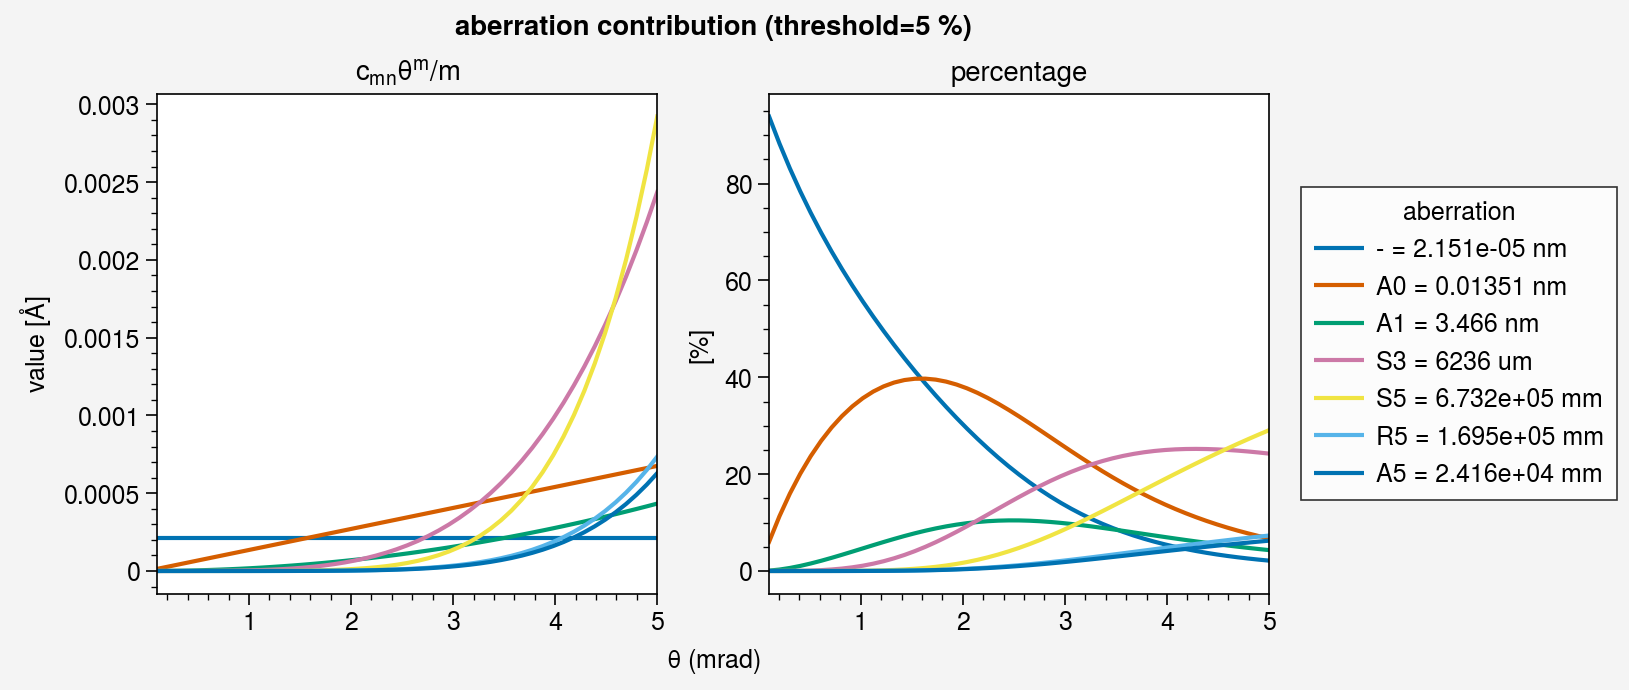

In [17]:
_ = fitaber.print_contribution(result_aber, attrs["semiconv"], threshold=5)
fitaber.plot_contribution(result_aber, attrs["semiconv"], threshold=5)

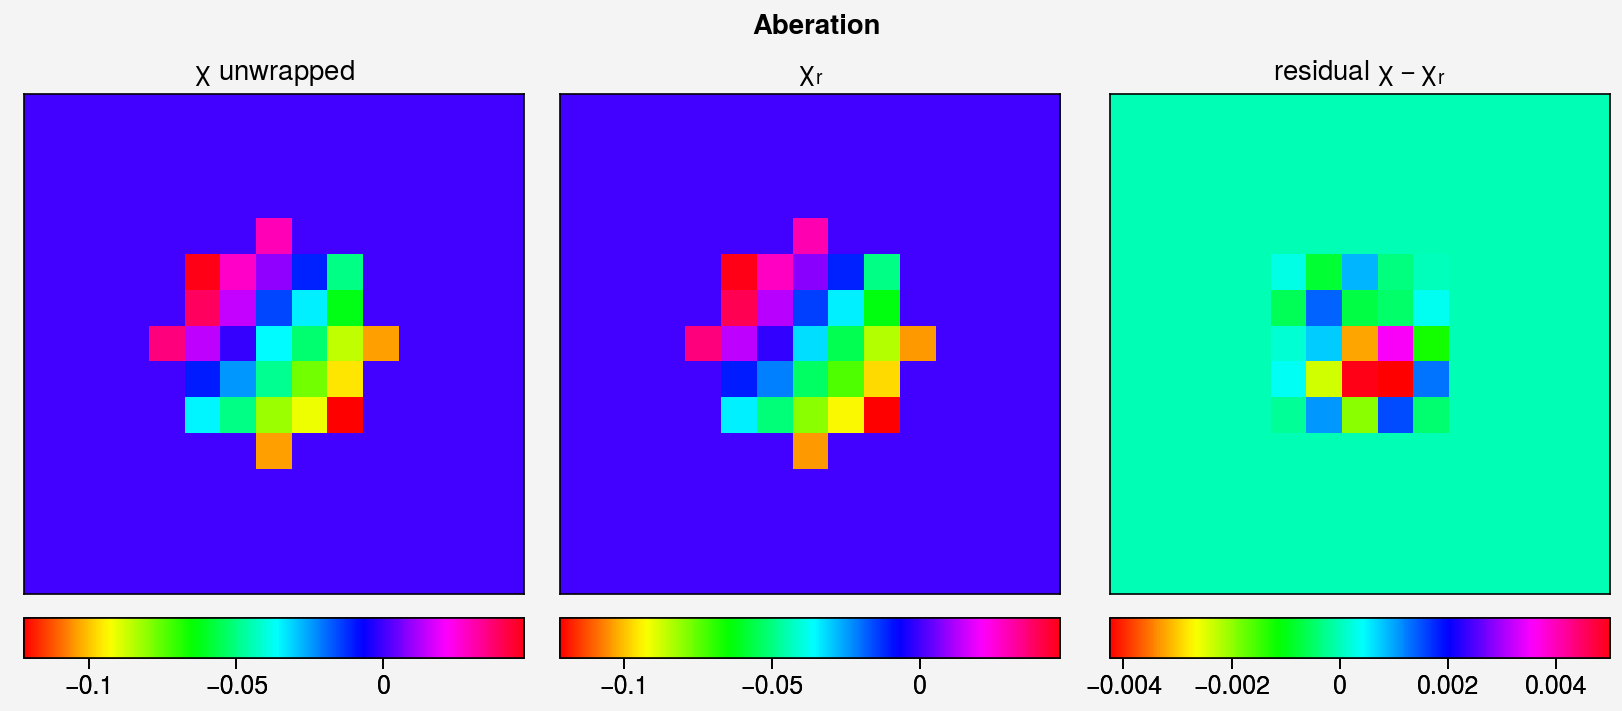

In [18]:
fig, axs = pplt.subplots(nrows=1, ncols=3, suptitle="Aberation",
                         xlim=(margin, chi.shape[1]-margin),
                         ylim=(margin, chi.shape[1]-margin),
                         xticks=[], yticks=[])
ax1, ax2, ax3 = axs

m = ax1.imshow(chi, cmap="hsv")
ax1.colorbar(m, loc="b")
ax1.format(title="$\chi$ unwrapped")

reconstaber = fitaber.aber(result_aber, chi.shape[0], resolution_reciprocal_space_rad) * aperture
m = ax2.imshow(reconstaber, cmap="hsv")
ax2.colorbar(m, loc="b")
ax2.format(title="$\chi_{\mathrm{r}}$")

residual = chi - reconstaber
m = ax3.imshow(residual, cmap="hsv")
ax3.colorbar(m, loc="b")
ax3.format(title="residual $\chi - \chi_{\mathrm{r}}$")

pplt.show()